In [64]:
import torch
from diffusers import DDPMPipeline, DDPMScheduler
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np
import random
from particles import state_space_models as ssm
import particles

In [65]:

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## **Importing a pre trained model**

In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist").to(device)
pipe.unet.eval()

Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

Printing example image 

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:33<00:00, 29.89it/s]


(-0.5, 27.5, 27.5, -0.5)

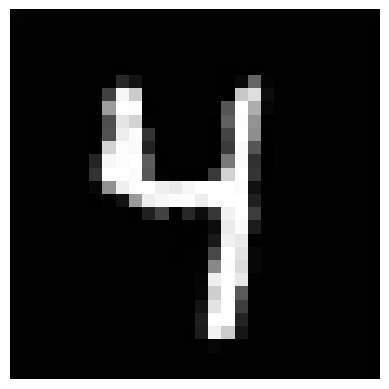

In [67]:
generator = torch.Generator(device=device).manual_seed(123)

with torch.no_grad():
    image = pipe(batch_size=1, generator= generator).images[0]

plt.imshow(image, cmap="gray")
plt.axis("off")


Inpatinting it 

(-0.5, 27.5, 27.5, -0.5)

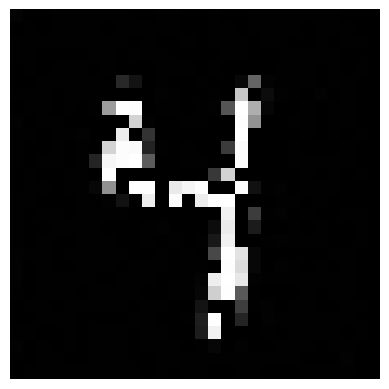

In [68]:
def create_inpainting_observation(x_true, missing_ratio=0.2, sigma_noise=0):

    mask = np.random.rand(*x_true.shape) > missing_ratio
    x_obs = np.copy(x_true)
    x_obs[~mask] = 0
    noise = np.random.normal(0, sigma_noise, size=x_true.shape)
    x_obs[mask] += noise[mask]
    
    return x_obs, mask


x0 = np.array(image).astype("float32")
y, A = create_inpainting_observation(x0, 0.4)


plt.imshow(y, cmap="gray")
plt.axis("off")

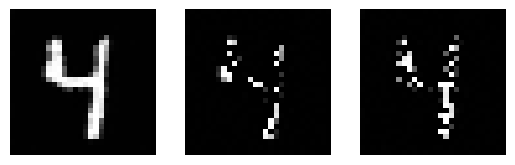

In [69]:
y_inp, A = create_inpainting_observation(x0, 0.6, 0)
y_inp_noise, A = create_inpainting_observation(x0, 0.6, 0.05)

images = [x0, y_inp, y_inp_noise]

fig, ax = plt.subplots(1, 3)
for k in range(3):
    ax[k].imshow(images[k], cmap = "gray")
    ax[k].axis("off")
  


## **Coding the SMC sampler**

Auxiliary functions : 

In [86]:
from particles import FeynmanKac as fk
from particles import distributions as dists
from particles import SMC

In [138]:
class NoiselessBackwardFK:
    def __init__(self, y, alphas, sigmas, pipeline, dx=None):
        """
        y        : observed vector in R^{dy}
        alphas   : array (alpha_0, ..., alpha_n)
        sigmas   : array (sigma_1, ..., sigma_n)
        pipeline : pretrained Hugging Face DDPMPipeline
        dx       : total dimension of x (including unobserved)
        """
        self.y = y
        self.dy = len(y)
        self.alphas = alphas
        self.sigmas = sigmas
        self.pipeline = pipeline
        self.nsteps = len(alphas) - 1
        self.T = self.nsteps
        self.dx = dx if dx is not None else self.dy 

    def done(self, *_args, **_kwargs):
        # Return True if finished, False otherwise
        return False
    
    @torch.no_grad()
    def chi(self, x, t):
        """
        Compute χ_θ^{0|t}(x_t) = ᾱ_t^{-1/2} x_t - sqrt(1 - ᾱ_t) * e_θ(x_t, t)
        """
        alpha_bar = self.alphas[t]

        # Convert x to a batch of images for UNet
        # If x is 2D (N, dx), reshape each particle
        N = x.shape[0] if len(x.shape) > 1 else 1
        img_size = int(np.sqrt(self.dx))  # assuming square images
        x_imgs = x.reshape(N, 1, img_size, img_size)  # (N, 1, H, W)

        x_tensor = torch.tensor(x_imgs, dtype=torch.float32)

        # UNet predicts noise
        t_tensor = torch.tensor([t] * N, dtype=torch.long)
        e_theta = self.pipeline.unet(x_tensor, t_tensor)[0]  # shape (N, 1, H, W)
        e_theta = e_theta.cpu().numpy().reshape(N, -1)       # flatten back to vector

        chi = x / np.sqrt(alpha_bar) - np.sqrt(1 - alpha_bar) * e_theta
        return chi

    def m(self, x_next, t):
        """
        Backward conditional mean using the Hugging Face model
        """
        chi = self.chi(x_next, t + 1)
        sigma2 = self.sigmas[t + 1]
        alpha_bar = self.alphas[t + 1]
        K_t = sigma2 / (sigma2 + 1 - alpha_bar)
        mean = K_t * np.sqrt(alpha_bar) * self.y + (1 - K_t) * chi
        return mean

    def M0(self, N):
        alpha_n = self.alphas[-1]
        sigma_n = self.sigmas[-1]
        K_n = sigma_n**2 / (sigma_n**2 + 1 - alpha_n)

        # Observed part
        mean_obs = K_n * np.sqrt(alpha_n) * self.y
        cov_obs = (1 - alpha_n) * K_n * np.eye(self.dy)
        non_inpainted_part = dists.MvNormal(loc=mean_obs, cov=cov_obs).rvs(N)

        # Unobserved part
        if self.dx > self.dy:
            mean_unobs = np.zeros(self.dx - self.dy)
            cov_unobs = np.eye(self.dx - self.dy)
            inpainted_part = dists.MvNormal(loc=mean_unobs, cov=cov_unobs).rvs(N)
            return np.hstack([non_inpainted_part, inpainted_part])
        else:
            return non_inpainted_part

    def M(self, s, xp):
        alpha_s = self.alphas[s]
        sigma_sp1 = self.sigmas[s + 1]
        K_s = sigma_sp1**2 / (sigma_sp1**2 + 1 - alpha_s)
        mean = K_s * np.sqrt(alpha_s) * self.y + (1 - K_s) * self.m(xp, s)
        cov = (1 - alpha_s) * K_s * np.eye(self.dy)

        # If xp is multiple particles, handle each row separately
        if len(xp.shape) == 2:  
            particles = np.array([dists.MvNormal(loc=m, cov=cov).rvs() for m in mean])
        else:
            particles = dists.MvNormal(loc=mean, cov=cov).rvs(len(xp))
        return particles

    def logG(self, s, xp, x):
        """
        Log potential for particle weights
        """
        if s == self.nsteps - 1:
            mean = self.m(xp, s)
            cov = (self.sigmas[self.nsteps]**2 + 1 - self.alphas[s]) * np.eye(self.dy)
            dist = dists.MvNormal(loc=mean, scale=cov)
            return dist.logpdf(np.sqrt(self.alphas[s]) * self.y)
        elif s >= 1:
            dist1 = dists.MvNormal(
                loc=self.m(xp, s),
                scale=(self.sigmas[s + 1]**2 + 1 - self.alphas[s]) * np.eye(self.dy)
            )
            dist2 = dists.MvNormal(
                loc=xp,
                scale=(1 - self.alphas[s + 1]) * np.eye(self.dy)
            )
            return dist1.logpdf(np.sqrt(self.alphas[s]) * self.y) - dist2.logpdf(np.sqrt(self.alphas[s + 1]) * self.y)
        else:
            # step s = 0
            p0 = dists.MvNormal(loc=self.m(xp, 0), scale=np.eye(self.dy))
            q10 = dists.MvNormal(scale=np.sqrt(self.alphas[1]) * self.y,
                        cov=(1 - self.alphas[1]) * np.eye(self.dy))
            return p0.logpdf(self.y) - q10.logpdf(xp)



**Example**

In [139]:
betas = torch.linspace(0.0001, 0.02, 1000)
alphas = 1 - betas
sigmas = torch.sqrt(betas)


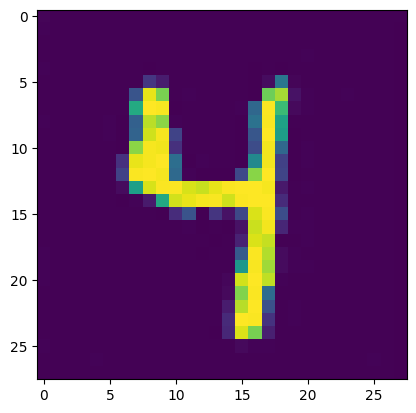

In [121]:
plt.imshow(x0)

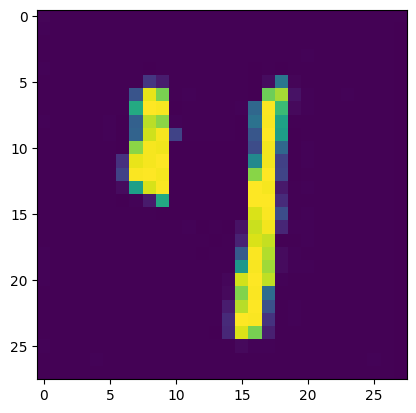

In [122]:
mask = np.ones_like(x0)
mask[10:16, 10:16] = 0  

y = x0[mask == 1]
x_masked = x0 * mask


plt.imshow(x_masked)

In [140]:
observed_flat = x0[mask == 1].flatten()  # observed pixels
unobserved_size = np.sum(mask == 0)  
dx = observed_flat.size + unobserved_size
y_obs = observed_flat

FKModel = NoiselessBackwardFK(y_obs, sigmas, alphas, pipe)


alg = SMC(
    fk=FKModel,
    N=10,  
    resampling='systematic',
)

alg.run()

AttributeError: 'NoneType' object has no attribute 'shape'

# **Whole pipeline**

In [81]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from diffusers import DDPMPipeline


(-0.5, 27.5, 27.5, -0.5)

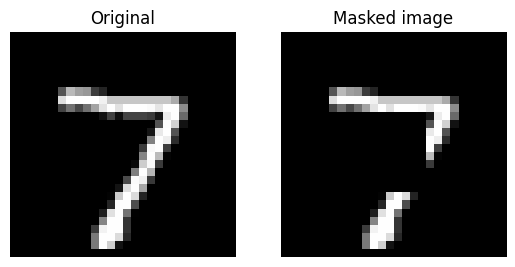

In [83]:
mnist = datasets.MNIST(
    root="./data", train=False, download=True,
    transform=transforms.ToTensor()
)
x0, label = mnist[0]
x0 = x0.numpy().squeeze()  

mask = np.ones_like(x0)
mask[10:20, 10:18] = 0

masked_img = x0 * mask

x0_flat = x0.flatten()
mask_flat = mask.flatten().astype(bool)

obs_idx = np.where(mask_flat)[0]
miss_idx = np.where(~mask_flat)[0]

y_obs = x0_flat[obs_idx]

dx = x0_flat.size
dy = len(obs_idx)

fig, ax = plt.subplots(1,2)

ax[0].imshow(x0, cmap="gray")
ax[0].set_title("Original")
ax[0].axis("off")

ax[1].imshow(masked_img, cmap="gray")
ax[1].set_title("Masked image")
ax[1].axis("off")


In [84]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist").to(device)
pipe.unet.eval()

Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 15.40it/s]


UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [85]:
class NoiselessBackwardFK:
    def __init__(self, y, obs_idx, miss_idx, alpha_bars, sigmas, pipeline, dx):
        self.y = y
        self.obs_idx = obs_idx
        self.miss_idx = miss_idx
        self.dy = len(obs_idx)
        self.alpha_bars = alpha_bars
        self.sigmas = sigmas
        self.pipeline = pipeline
        self.dx = dx
        self.nsteps = len(alpha_bars) - 1

    @torch.no_grad()
    def chi(self, x, t):
        x = np.atleast_2d(x)
        N = x.shape[0]
        img_size = int(np.sqrt(self.dx))

        x_img = x.reshape(N, 1, img_size, img_size)
        x_tensor = torch.tensor(x_img, dtype=torch.float32, device=device)
        t_tensor = torch.full((N,), t, device=device, dtype=torch.long)

        eps = self.pipeline.unet(x_tensor, t_tensor)[0]
        eps = eps.cpu().numpy().reshape(N, -1)

        return (
            x / np.sqrt(self.alpha_bars[t])
            - np.sqrt(1 - self.alpha_bars[t]) * eps
        )

    def m(self, x_next, t):
        chi = self.chi(x_next, t + 1)
        sigma2 = self.sigmas[t + 1] ** 2
        alpha_bar = self.alpha_bars[t + 1]

        Kt = sigma2 / (sigma2 + 1 - alpha_bar)

        mean = chi.copy()
        mean[:, self.obs_idx] = (
            Kt * np.sqrt(alpha_bar) * self.y
            + (1 - Kt) * chi[:, self.obs_idx]
        )
        return mean

    def M0(self, N):
        particles = np.zeros((N, self.dx))

        alpha_n = self.alpha_bars[-1]
        sigma_n = self.sigmas[-1]
        Kn = sigma_n**2 / (sigma_n**2 + 1 - alpha_n)

        mean_obs = Kn * np.sqrt(alpha_n) * self.y
        cov_obs = (1 - alpha_n) * Kn * np.eye(self.dy)

        particles[:, self.obs_idx] = np.random.multivariate_normal(
            mean_obs, cov_obs, size=N
        )

        particles[:, self.miss_idx] = np.random.randn(N, len(self.miss_idx))
        return particles

    def M(self, s, xp):
        mean = self.m(xp, s)

        alpha_s = self.alpha_bars[s]
        sigma_sp1 = self.sigmas[s + 1]
        Ks = sigma_sp1**2 / (sigma_sp1**2 + 1 - alpha_s)

        cov_obs = (1 - alpha_s) * Ks * np.eye(self.dy)

        new_obs = np.array([
            np.random.multivariate_normal(mean=m[self.obs_idx], cov=cov_obs)
            for m in mean
        ])

        xp_new = xp.copy()
        xp_new[:, self.obs_idx] = new_obs
        return xp_new


class PseudoSMC:
    def __init__(self, fk, N=10):
        self.fk = fk
        self.N = N

    def compute_weights(self, particles, s):
        mean = self.fk.m(particles, s)
        cov = self.fk.sigmas[s + 1]**2 + 1 - self.fk.alpha_bars[s]

        log_w = np.zeros(self.N)
        for i in range(self.N):
            diff = (
                np.sqrt(self.fk.alpha_bars[s]) * self.fk.y
                - mean[i, self.fk.obs_idx]
            )
            log_w[i] = (
                -0.5 * diff @ diff / cov
                - 0.5 * self.fk.dy * np.log(2 * np.pi * cov)
            )

        log_w -= np.max(log_w)
        w = np.exp(log_w)

        if np.sum(w) == 0 or np.isnan(np.sum(w)):
            return np.ones(self.N) / self.N
        return w / np.sum(w)

    def resample(self, particles, weights):
        idx = np.random.choice(self.N, self.N, replace=True, p=weights)
        return particles[idx]

    def run(self):
        particles = self.fk.M0(self.N)
        for s in reversed(range(self.fk.nsteps)):
            w = self.compute_weights(particles, s)
            particles = self.resample(particles, w)
            particles = self.fk.M(s, particles)
        return particles

In [86]:
num_timesteps = pipe.scheduler.num_train_timesteps
betas = np.linspace(0.0001, 0.02, num_timesteps)
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas)
sigmas = np.sqrt(betas)

# Subsample timesteps
n_steps = 50
step_idx = np.linspace(0, num_timesteps - 1, n_steps, dtype=int)
alpha_bars = alpha_bars[step_idx]
sigmas = sigmas[step_idx]


fk = NoiselessBackwardFK(
    y=y_obs,
    obs_idx=obs_idx,
    miss_idx=miss_idx,
    alpha_bars=alpha_bars,
    sigmas=sigmas,
    pipeline=pipe,
    dx=dx
)

smc = PseudoSMC(fk, N=5)
particles_final = smc.run()


/home/perann/miniconda3/envs/smc_sampling/lib/python3.12/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


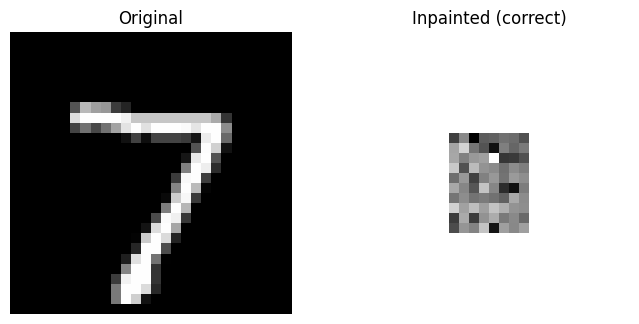

In [87]:
recon = particles_final.mean(axis=0).reshape(28, 28)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(x0, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(recon, cmap="gray")
plt.title("Inpainted (correct)")
plt.axis("off")
plt.show()


Calibration

In [96]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from diffusers import DDPMPipeline

# ======================================================
# Data
# ======================================================
mnist = datasets.MNIST(
    root="./data", train=False, download=True,
    transform=transforms.ToTensor()
)
x0, label = mnist[0]
x0 = x0.numpy().squeeze()

mask = np.ones_like(x0)
mask[10:20, 10:18] = 0
masked_img = x0 * mask

x0_flat = x0.flatten()
mask_flat = mask.flatten().astype(bool)

obs_idx = np.where(mask_flat)[0]
miss_idx = np.where(~mask_flat)[0]

y_obs = x0_flat[obs_idx]
dx = x0_flat.size
dy = len(obs_idx)

# ======================================================
# Model
# ======================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist").to(device)
pipe.unet.eval()

# ======================================================
# FK model
# ======================================================
class NoiselessBackwardFK:
    def __init__(self, y, obs_idx, miss_idx, alpha_bars, sigmas, pipeline, dx):
        self.y = y
        self.obs_idx = obs_idx
        self.miss_idx = miss_idx
        self.dy = len(obs_idx)
        self.alpha_bars = alpha_bars
        self.sigmas = sigmas
        self.pipeline = pipeline
        self.dx = dx
        self.nsteps = len(alpha_bars) - 1

    @torch.no_grad()
    def chi(self, x, t):
        x = np.atleast_2d(x)
        N = x.shape[0]
        img_size = int(np.sqrt(self.dx))

        x_img = x.reshape(N, 1, img_size, img_size)
        x_tensor = torch.tensor(x_img, dtype=torch.float32, device=device)
        t_tensor = torch.full((N,), t, device=device, dtype=torch.long)

        eps = self.pipeline.unet(x_tensor, t_tensor)[0]
        eps = eps.cpu().numpy().reshape(N, -1)

        return (
            x / np.sqrt(self.alpha_bars[t])
            - np.sqrt(1 - self.alpha_bars[t]) * eps
        )

    def m(self, x_next, t):
        chi = self.chi(x_next, t + 1)
        sigma2 = self.sigmas[t + 1] ** 2
        alpha_bar = self.alpha_bars[t + 1]

        Kt = sigma2 / (sigma2 + 1 - alpha_bar)

        mean = chi.copy()
        mean[:, self.obs_idx] = (
            Kt * np.sqrt(alpha_bar) * self.y
            + (1 - Kt) * chi[:, self.obs_idx]
        )
        return mean

    def M0(self, N):
        particles = np.zeros((N, self.dx))

        alpha_n = self.alpha_bars[-1]
        sigma_n = self.sigmas[-1]
        Kn = sigma_n**2 / (sigma_n**2 + 1 - alpha_n)

        mean_obs = Kn * np.sqrt(alpha_n) * self.y
        cov_obs = (1 - alpha_n) * Kn * np.eye(self.dy)

        particles[:, self.obs_idx] = np.random.multivariate_normal(
            mean_obs, cov_obs, size=N
        )
        particles[:, self.miss_idx] = np.random.randn(N, len(self.miss_idx))
        return particles

    def M(self, s, xp):
        mean = self.m(xp, s)

        alpha_s = self.alpha_bars[s]
        sigma_sp1 = self.sigmas[s + 1]
        Ks = sigma_sp1**2 / (sigma_sp1**2 + 1 - alpha_s)

        cov_obs = (1 - alpha_s) * Ks * np.eye(self.dy)

        new_obs = np.array([
            np.random.multivariate_normal(mean=m[self.obs_idx], cov=cov_obs)
            for m in mean
        ])

        xp_new = xp.copy()
        xp_new[:, self.obs_idx] = new_obs
        return xp_new

# ======================================================
# Pseudo-SMC with snapshot saving
# ======================================================
class PseudoSMC:
    def __init__(self, fk, N=5, save_dir="manual_smc_res", save_every=5):
        self.fk = fk
        self.N = N
        self.save_every = save_every
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

    def compute_weights(self, particles, s):
        mean = self.fk.m(particles, s)
        cov = self.fk.sigmas[s + 1]**2 + 1 - self.fk.alpha_bars[s]

        log_w = np.zeros(self.N)
        for i in range(self.N):
            diff = (
                np.sqrt(self.fk.alpha_bars[s]) * self.fk.y
                - mean[i, self.fk.obs_idx]
            )
            log_w[i] = (
                -0.5 * diff @ diff / cov
                - 0.5 * self.fk.dy * np.log(2 * np.pi * cov)
            )

        log_w -= np.max(log_w)
        w = np.exp(log_w)

        if np.sum(w) == 0 or np.isnan(np.sum(w)):
            return np.ones(self.N) / self.N
        return w / np.sum(w)

    def resample(self, particles, weights):
        idx = np.random.choice(self.N, self.N, replace=True, p=weights)
        return particles[idx]

    def save_snapshot(self, particles, step):
        img = particles.mean(axis=0).reshape(28, 28)
        plt.imsave(
            f"{self.save_dir}/step_{step:04d}.png",
            img,
            cmap="gray"
        )

    def run(self):
        particles = self.fk.M0(self.N)

        for s in reversed(range(self.fk.nsteps)):
            if s % self.save_every == 0:
                self.save_snapshot(particles, s)

            w = self.compute_weights(particles, s)
            particles = self.resample(particles, w)
            particles = self.fk.M(s, particles)

        return particles

# ======================================================
# Scheduler (FULL 1000 steps)
# ======================================================
num_timesteps = pipe.scheduler.num_train_timesteps
betas = np.linspace(0.0001, 0.02, num_timesteps)
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas)
sigmas = np.sqrt(betas)

# ======================================================
# Run
# ======================================================
fk = NoiselessBackwardFK(
    y=y_obs,
    obs_idx=obs_idx,
    miss_idx=miss_idx,
    alpha_bars=alpha_bars,
    sigmas=sigmas,
    pipeline=pipe,
    dx=dx
)

smc = PseudoSMC(fk, N=20, save_every=5)
particles_final = smc.run()

# ======================================================
# Final reconstruction
# ======================================================
recon = particles_final.mean(axis=0).reshape(28, 28)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(x0, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(recon, cmap="gray")
plt.title("Inpainted (final)")
plt.axis("off")
plt.show()



Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 29.11it/s]


KeyboardInterrupt: 

Collapses too fast, I train my own DDPM on collab and use it

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm

# --- Dataset ---
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- UNet-like model for 28x28 images ---
class SmallUNet(nn.Module):
    def __init__(self, in_ch=1, base_ch=64):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(in_ch, base_ch, 3, 1, 1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(base_ch, base_ch*2, 3, 2, 1), nn.ReLU())
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(base_ch*2, base_ch, 4, 2, 1), nn.ReLU())
        self.out = nn.Conv2d(base_ch, in_ch, 3, 1, 1)

    def forward(self, x, t):
        h = self.enc1(x)
        h = self.enc2(h)
        h = self.dec1(h)
        return self.out(h)  # predict epsilon

model = SmallUNet().to(device)

# --- DDPM parameters ---
num_timesteps = 100
beta_start, beta_end = 0.001, 0.05
betas = np.linspace(beta_start, beta_end, num_timesteps)
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()

# --- Training loop ---
epochs = 20
for epoch in range(epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for x, _ in pbar:
        x = x.to(device)
        b, c, h, w = x.shape
        t = torch.randint(0, num_timesteps, (b,), device=device).long()

        # sample noise
        eps = torch.randn_like(x)
        # forward diffusion: x_t = sqrt(alpha_bar) * x0 + sqrt(1-alpha_bar) * eps
        alpha_bars_t = torch.tensor(alpha_bars[t.cpu()], device=device).float().view(-1,1,1,1)
        x_t = torch.sqrt(alpha_bars_t) * x + torch.sqrt(1 - alpha_bars_t) * eps

        eps_pred = model(x_t, t)
        loss = mse(eps_pred, eps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix({"loss": loss.item()})

# --- Save weights ---
torch.save(model.state_dict(), "ddpm_mnist.pt")
print("Training done, weights saved as ddpm_mnist.pt")

100 timestep, shallow unets, 20 epochs :

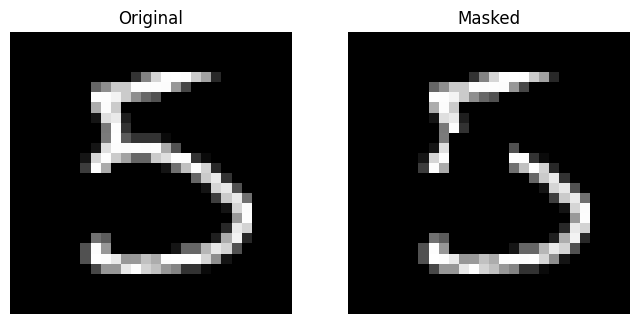

Step 95: 10 valid, 0 degenerate particles
Step 90: 10 valid, 0 degenerate particles
Step 85: 10 valid, 0 degenerate particles
Step 80: 10 valid, 0 degenerate particles
Step 75: 10 valid, 0 degenerate particles
Step 70: 10 valid, 0 degenerate particles
Step 65: 10 valid, 0 degenerate particles
Step 60: 10 valid, 0 degenerate particles
Step 55: 10 valid, 0 degenerate particles
Step 50: 10 valid, 0 degenerate particles
Step 45: 10 valid, 0 degenerate particles
Step 40: 10 valid, 0 degenerate particles
Step 35: 10 valid, 0 degenerate particles
Step 30: 10 valid, 0 degenerate particles
Step 25: 10 valid, 0 degenerate particles
Step 20: 10 valid, 0 degenerate particles
Step 15: 10 valid, 0 degenerate particles
Step 10: 10 valid, 0 degenerate particles
Step 5: 10 valid, 0 degenerate particles
Step 0: 10 valid, 0 degenerate particles


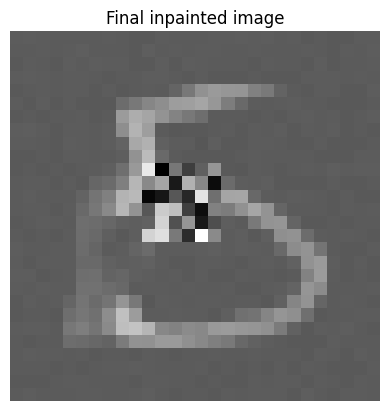

In [117]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load MNIST ---
mnist = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())
x0, label = mnist[15]
x0 = x0.numpy().squeeze()

# --- Mask ---
mask = np.ones_like(x0)
mask[10:16, 10:16] = 0
masked_img = x0 * mask

# --- Flatten for SMC ---
x0_flat = x0.flatten()
mask_flat = mask.flatten().astype(bool)
obs_idx = np.where(mask_flat)[0]
miss_idx = np.where(~mask_flat)[0]
y_obs = x0_flat[obs_idx]
dx = x0_flat.size
dy = len(obs_idx)

# --- Display original and masked ---
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(x0, cmap="gray"); ax[0].set_title("Original"); ax[0].axis("off")
ax[1].imshow(masked_img, cmap="gray"); ax[1].set_title("Masked"); ax[1].axis("off")
plt.show()

# --- Load your trained SmallUNet ---
class SmallUNet(torch.nn.Module):
    def __init__(self, in_ch=1, base_ch=64):
        super().__init__()
        self.enc1 = torch.nn.Sequential(torch.nn.Conv2d(in_ch, base_ch, 3, 1, 1), torch.nn.ReLU())
        self.enc2 = torch.nn.Sequential(torch.nn.Conv2d(base_ch, base_ch*2, 3, 2, 1), torch.nn.ReLU())
        self.dec1 = torch.nn.Sequential(torch.nn.ConvTranspose2d(base_ch*2, base_ch, 4, 2, 1), torch.nn.ReLU())
        self.out = torch.nn.Conv2d(base_ch, in_ch, 3, 1, 1)

    def forward(self, x, t):
        h = self.enc1(x)
        h = self.enc2(h)
        h = self.dec1(h)
        return self.out(h)

unet = SmallUNet().to(device)
unet.load_state_dict(torch.load("ddpm_mnist.pt", map_location=device))
unet.eval()

# --- Forward schedule ---
num_timesteps = 100
beta_start, beta_end = 0.001, 0.05
betas = np.linspace(beta_start, beta_end, num_timesteps)
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas)
sigmas = np.sqrt(betas)

# --- Backward FK ---
class NoiselessBackwardFK:
    def __init__(self, y, obs_idx, miss_idx, alpha_bars, sigmas, model, dx):
        self.y = y
        self.obs_idx = obs_idx
        self.miss_idx = miss_idx
        self.dy = len(obs_idx)
        self.alpha_bars = alpha_bars
        self.sigmas = sigmas
        self.model = model
        self.dx = dx
        self.nsteps = len(alpha_bars) - 1

    @torch.no_grad()
    def chi(self, x, t):
        x = np.atleast_2d(x)
        N = x.shape[0]
        img_size = int(np.sqrt(self.dx))
        x_img = x.reshape(N, 1, img_size, img_size)
        x_tensor = torch.tensor(x_img, dtype=torch.float32, device=device)
        t_tensor = torch.full((N,), t, device=device, dtype=torch.long)
        eps = self.model(x_tensor, t_tensor).cpu().numpy().reshape(N, -1)
        return x / np.sqrt(self.alpha_bars[t]) - np.sqrt(1 - self.alpha_bars[t]) * eps

    def m(self, x_next, t):
        chi = self.chi(x_next, t + 1)
        sigma2 = self.sigmas[t + 1]**2
        alpha_bar = self.alpha_bars[t + 1]
        Kt = sigma2 / (sigma2 + 1 - alpha_bar)
        mean = chi.copy()
        mean[:, self.obs_idx] = Kt * np.sqrt(alpha_bar) * self.y + (1 - Kt) * chi[:, self.obs_idx]
        return mean

    def M0(self, N):
        particles = np.zeros((N, self.dx))
        alpha_n = self.alpha_bars[-1]
        sigma_n = self.sigmas[-1]
        Kn = sigma_n**2 / (sigma_n**2 + 1 - alpha_n)
        mean_obs = Kn * np.sqrt(alpha_n) * self.y
        cov_obs = (1 - alpha_n) * Kn * np.eye(self.dy)
        particles[:, self.obs_idx] = np.random.multivariate_normal(mean_obs, cov_obs, size=N)
        particles[:, self.miss_idx] = np.random.randn(N, len(self.miss_idx))
        return particles

    def M(self, s, xp):
        mean = self.m(xp, s)
        alpha_s = self.alpha_bars[s]
        sigma_sp1 = self.sigmas[s + 1]
        Ks = sigma_sp1**2 / (sigma_sp1**2 + 1 - alpha_s)
        cov_obs = (1 - alpha_s) * Ks * np.eye(self.dy)
        new_obs = np.array([np.random.multivariate_normal(mean=m[self.obs_idx], cov=cov_obs) for m in mean])
        xp_new = xp.copy()
        xp_new[:, self.obs_idx] = new_obs
        return xp_new

# --- PseudoSMC with snapshot saving ---
class PseudoSMC:
    def __init__(self, fk, N=5, snapshot_dir="./manual_smc_res"):
        self.fk = fk
        self.N = N
        self.snapshot_dir = snapshot_dir
        os.makedirs(snapshot_dir, exist_ok=True)

    def compute_weights(self, particles, s):
        mean = self.fk.m(particles, s)
        cov = self.fk.sigmas[s + 1]**2 + 1 - self.fk.alpha_bars[s]
        log_w = np.zeros(self.N)
        for i in range(self.N):
            diff = np.sqrt(self.fk.alpha_bars[s]) * self.fk.y - mean[i, self.fk.obs_idx]
            log_w[i] = -0.5 * diff @ diff / cov - 0.5 * self.fk.dy * np.log(2 * np.pi * cov)
        log_w -= np.max(log_w)
        w = np.exp(log_w)
        if np.sum(w) == 0 or np.isnan(np.sum(w)):
            return np.ones(self.N) / self.N
        return w / np.sum(w)

    def resample(self, particles, weights):
        idx = np.random.choice(self.N, self.N, replace=True, p=weights)
        return particles[idx]

    def run(self, snapshot_every=5):
        particles = self.fk.M0(self.N)
        for s in reversed(range(self.fk.nsteps)):
            w = self.compute_weights(particles, s)
            particles = self.resample(particles, w)
            particles = self.fk.M(s, particles)
            if s % snapshot_every == 0:
                is_valid = np.all(np.isfinite(particles), axis=1)
                n_valid = np.sum(is_valid)
                n_degen = self.N - n_valid

                if n_valid > 0:
                    recon = particles[is_valid].mean(axis=0).reshape(28, 28)
                else:
                    recon = np.zeros((28,28))

                filename = os.path.join(self.snapshot_dir, f"step_{s:04d}.png")
                plt.imsave(filename, recon, cmap="gray")
                print(f"Step {s}: {n_valid} valid, {n_degen} degenerate particles")
                plt.imsave(os.path.join(self.snapshot_dir, f"step_{s:04d}.png"), recon, cmap="gray")
        return particles

# --- Run full SMC ---
fk = NoiselessBackwardFK(y=y_obs, obs_idx=obs_idx, miss_idx=miss_idx,
                          alpha_bars=alpha_bars, sigmas=sigmas,
                          model=unet, dx=dx)

smc = PseudoSMC(fk, N=10)
particles_final = smc.run(snapshot_every=5)

# --- Show final reconstruction ---
recon = particles_final.mean(axis=0).reshape(28,28)
plt.imshow(recon, cmap="gray")
plt.title("Final inpainted image")
plt.axis("off")
plt.show()



Not precise enough

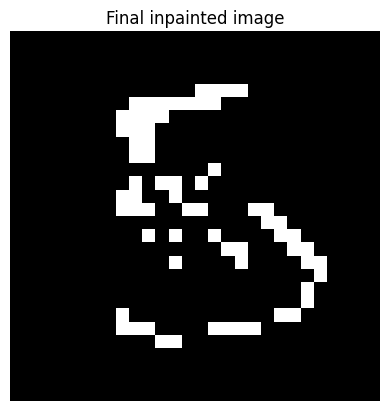

In [113]:
recon = np.clip(recon, 0, 1)
recon[recon < 0.5] = 0
recon[recon >= 0.5] = 1

plt.imshow(recon, cmap="gray")
plt.title("Final inpainted image")
plt.axis("off")
plt.show()

200 timestep, imp unet, 50 epochs : degenerate 

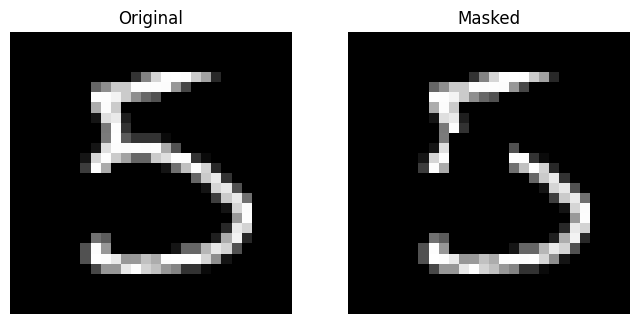

Step 195: 50 valid, 0 degenerate particles
Step 190: 50 valid, 0 degenerate particles
Step 185: 50 valid, 0 degenerate particles
Step 180: 50 valid, 0 degenerate particles
Step 175: 50 valid, 0 degenerate particles
Step 170: 50 valid, 0 degenerate particles
Step 165: 50 valid, 0 degenerate particles
Step 160: 50 valid, 0 degenerate particles
Step 155: 50 valid, 0 degenerate particles
Step 150: 0 valid, 50 degenerate particles
Step 145: 0 valid, 50 degenerate particles
Step 140: 0 valid, 50 degenerate particles
Step 135: 0 valid, 50 degenerate particles
Step 130: 0 valid, 50 degenerate particles
Step 125: 0 valid, 50 degenerate particles
Step 120: 0 valid, 50 degenerate particles
Step 115: 0 valid, 50 degenerate particles
Step 110: 0 valid, 50 degenerate particles


KeyboardInterrupt: 

In [115]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load MNIST ---
mnist = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())
x0, label = mnist[15]
x0 = x0.numpy().squeeze()

# --- Mask ---
mask = np.ones_like(x0)
mask[10:16, 10:16] = 0
masked_img = x0 * mask

# --- Flatten for SMC ---
x0_flat = x0.flatten()
mask_flat = mask.flatten().astype(bool)
obs_idx = np.where(mask_flat)[0]
miss_idx = np.where(~mask_flat)[0]
y_obs = x0_flat[obs_idx]
dx = x0_flat.size
dy = len(obs_idx)

# --- Display original and masked ---
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(x0, cmap="gray"); ax[0].set_title("Original"); ax[0].axis("off")
ax[1].imshow(masked_img, cmap="gray"); ax[1].set_title("Masked"); ax[1].axis("off")
plt.show()

# --- Load your trained SmallUNet ---
class ImprovedUNet(nn.Module):
    def __init__(self, in_ch=1, base_ch=64):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(nn.Conv2d(in_ch, base_ch, 3, 1, 1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(base_ch, base_ch*2, 3, 2, 1), nn.ReLU())
        self.enc3 = nn.Sequential(nn.Conv2d(base_ch*2, base_ch*2, 3, 1, 1), nn.ReLU())
        # Decoder
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(base_ch*2, base_ch*2, 4, 2, 1), nn.ReLU())
        self.dec2 = nn.Sequential(nn.Conv2d(base_ch*2, base_ch, 3, 1, 1), nn.ReLU())
        self.out = nn.Conv2d(base_ch, in_ch, 3, 1, 1)

    def forward(self, x, t):
        h = self.enc1(x)
        h = self.enc2(h)
        h = self.enc3(h)
        h = self.dec1(h)
        h = self.dec2(h)
        return self.out(h) 
    

unet = ImprovedUNet().to(device)
unet.load_state_dict(torch.load("ddpm_mnist_200.pt", map_location=device))
unet.eval()

# --- Forward schedule ---
num_timesteps = 200
beta_start, beta_end = 0.001, 0.05
betas = np.linspace(beta_start, beta_end, num_timesteps, dtype=np.float32)
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas)
sigmas = np.sqrt(betas)

# --- Backward FK ---
class NoiselessBackwardFK:
    def __init__(self, y, obs_idx, miss_idx, alpha_bars, sigmas, model, dx):
        self.y = y
        self.obs_idx = obs_idx
        self.miss_idx = miss_idx
        self.dy = len(obs_idx)
        self.alpha_bars = alpha_bars
        self.sigmas = sigmas
        self.model = model
        self.dx = dx
        self.nsteps = len(alpha_bars) - 1

    @torch.no_grad()
    def chi(self, x, t):
        x = np.atleast_2d(x)
        N = x.shape[0]
        img_size = int(np.sqrt(self.dx))
        x_img = x.reshape(N, 1, img_size, img_size)
        x_tensor = torch.tensor(x_img, dtype=torch.float32, device=device)
        t_tensor = torch.full((N,), t, device=device, dtype=torch.long)
        eps = self.model(x_tensor, t_tensor).cpu().numpy().reshape(N, -1)
        return x / np.sqrt(self.alpha_bars[t]) - np.sqrt(1 - self.alpha_bars[t]) * eps

    def m(self, x_next, t):
        chi = self.chi(x_next, t + 1)
        sigma2 = self.sigmas[t + 1]**2
        alpha_bar = self.alpha_bars[t + 1]
        Kt = sigma2 / (sigma2 + 1 - alpha_bar)
        mean = chi.copy()
        mean[:, self.obs_idx] = Kt * np.sqrt(alpha_bar) * self.y + (1 - Kt) * chi[:, self.obs_idx]
        return mean

    def M0(self, N):
        particles = np.zeros((N, self.dx))
        alpha_n = self.alpha_bars[-1]
        sigma_n = self.sigmas[-1]
        Kn = sigma_n**2 / (sigma_n**2 + 1 - alpha_n)
        mean_obs = Kn * np.sqrt(alpha_n) * self.y
        cov_obs = (1 - alpha_n) * Kn * np.eye(self.dy)
        particles[:, self.obs_idx] = np.random.multivariate_normal(mean_obs, cov_obs, size=N)
        particles[:, self.miss_idx] = np.random.randn(N, len(self.miss_idx))
        return particles

    def M(self, s, xp):
        mean = self.m(xp, s)
        alpha_s = self.alpha_bars[s]
        sigma_sp1 = self.sigmas[s + 1]
        Ks = sigma_sp1**2 / (sigma_sp1**2 + 1 - alpha_s)
        cov_obs = (1 - alpha_s) * Ks * np.eye(self.dy)
        new_obs = np.array([np.random.multivariate_normal(mean=m[self.obs_idx], cov=cov_obs) for m in mean])
        xp_new = xp.copy()
        xp_new[:, self.obs_idx] = new_obs
        return xp_new

# --- PseudoSMC with snapshot saving ---
class PseudoSMC:
    def __init__(self, fk, N=5, snapshot_dir="./manual_smc_res"):
        self.fk = fk
        self.N = N
        self.snapshot_dir = snapshot_dir
        os.makedirs(snapshot_dir, exist_ok=True)

    def compute_weights(self, particles, s):
        mean = self.fk.m(particles, s)
        cov = self.fk.sigmas[s + 1]**2 + 1 - self.fk.alpha_bars[s]
        log_w = np.zeros(self.N)
        for i in range(self.N):
            diff = np.sqrt(self.fk.alpha_bars[s]) * self.fk.y - mean[i, self.fk.obs_idx]
            log_w[i] = -0.5 * diff @ diff / cov - 0.5 * self.fk.dy * np.log(2 * np.pi * cov)
        log_w -= np.max(log_w)
        w = np.exp(log_w)
        if np.sum(w) == 0 or np.isnan(np.sum(w)):
            return np.ones(self.N) / self.N
        return w / np.sum(w)

    def resample(self, particles, weights):
        idx = np.random.choice(self.N, self.N, replace=True, p=weights)
        return particles[idx]

    def run(self, snapshot_every=5):
        particles = self.fk.M0(self.N)
        for s in reversed(range(self.fk.nsteps)):
            w = self.compute_weights(particles, s)
            particles = self.resample(particles, w)
            particles = self.fk.M(s, particles)
            if s % snapshot_every == 0:
                is_valid = np.all(np.isfinite(particles), axis=1)
                n_valid = np.sum(is_valid)
                n_degen = self.N - n_valid

                if n_valid > 0:
                    recon = particles[is_valid].mean(axis=0).reshape(28, 28)
                else:
                    recon = np.zeros((28,28))

                filename = os.path.join(self.snapshot_dir, f"step_{s:04d}.png")
                plt.imsave(filename, recon, cmap="gray")
                print(f"Step {s}: {n_valid} valid, {n_degen} degenerate particles")

        return particles

# --- Run full SMC ---
fk = NoiselessBackwardFK(y=y_obs, obs_idx=obs_idx, miss_idx=miss_idx,
                          alpha_bars=alpha_bars, sigmas=sigmas,
                          model=unet, dx=dx)

smc = PseudoSMC(fk, N=50)
particles_final = smc.run(snapshot_every=5)

# --- Show final reconstruction ---
recon = particles_final.mean(axis=0).reshape(28,28)
plt.imshow(recon, cmap="gray")
plt.title("Final inpainted image")
plt.axis("off")
plt.show()


100 time steps, improved Unet, 50 epochs

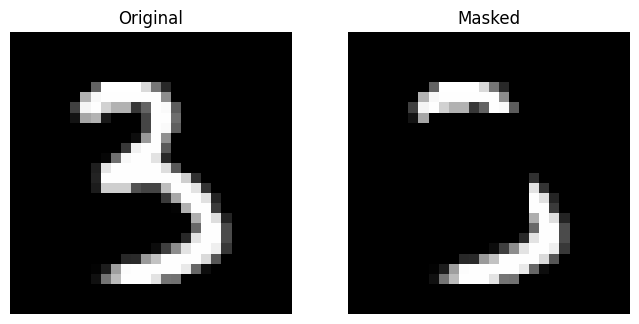

Step 50: 5 valid, 0 degenerate particles
Step 0: 5 valid, 0 degenerate particles


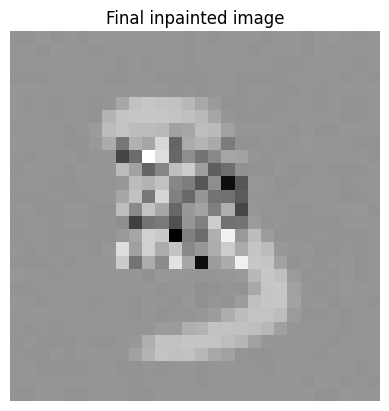

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn 

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load MNIST ---
mnist = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())
x0, label = mnist[32]
x0 = x0.numpy().squeeze()

# --- Mask ---
mask = np.ones_like(x0)
mask[8:18,8:18] = 0
masked_img = x0 * mask

# --- Flatten for SMC ---
x0_flat = x0.flatten()
mask_flat = mask.flatten().astype(bool)
obs_idx = np.where(mask_flat)[0]
miss_idx = np.where(~mask_flat)[0]
y_obs = x0_flat[obs_idx]
dx = x0_flat.size
dy = len(obs_idx)

# --- Display original and masked ---
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(x0, cmap="gray"); ax[0].set_title("Original"); ax[0].axis("off")
ax[1].imshow(masked_img, cmap="gray"); ax[1].set_title("Masked"); ax[1].axis("off")
plt.show()

# --- Load your trained SmallUNet ---
class ImprovedUNet(nn.Module):
    def __init__(self, in_ch=1, base_ch=64):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(nn.Conv2d(in_ch, base_ch, 3, 1, 1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(base_ch, base_ch*2, 3, 2, 1), nn.ReLU())
        self.enc3 = nn.Sequential(nn.Conv2d(base_ch*2, base_ch*2, 3, 1, 1), nn.ReLU())
        # Decoder
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(base_ch*2, base_ch*2, 4, 2, 1), nn.ReLU())
        self.dec2 = nn.Sequential(nn.Conv2d(base_ch*2, base_ch, 3, 1, 1), nn.ReLU())
        self.out = nn.Conv2d(base_ch, in_ch, 3, 1, 1)

    def forward(self, x, t):
        h = self.enc1(x)
        h = self.enc2(h)
        h = self.enc3(h)
        h = self.dec1(h)
        h = self.dec2(h)
        return self.out(h) 
    

unet = ImprovedUNet().to(device)
unet.load_state_dict(torch.load("ddpm_mnist_100_50e_impunet.pt", map_location=device))
unet.eval()
# --- Forward schedule ---
num_timesteps = 100
beta_start, beta_end = 0.001, 0.05
betas = np.linspace(beta_start, beta_end, num_timesteps)
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas)
sigmas = np.sqrt(betas)

# --- Backward FK ---
class NoiselessBackwardFK:
    def __init__(self, y, obs_idx, miss_idx, alpha_bars, sigmas, model, dx):
        self.y = y
        self.obs_idx = obs_idx
        self.miss_idx = miss_idx
        self.dy = len(obs_idx)
        self.alpha_bars = alpha_bars
        self.sigmas = sigmas
        self.model = model
        self.dx = dx
        self.nsteps = len(alpha_bars) - 1

    @torch.no_grad()
    def chi(self, x, t):
        x = np.atleast_2d(x)
        N = x.shape[0]
        img_size = int(np.sqrt(self.dx))
        x_img = x.reshape(N, 1, img_size, img_size)
        x_tensor = torch.tensor(x_img, dtype=torch.float32, device=device)
        t_tensor = torch.full((N,), t, device=device, dtype=torch.long)
        eps = self.model(x_tensor, t_tensor).cpu().numpy().reshape(N, -1)
        return x / np.sqrt(self.alpha_bars[t]) - np.sqrt(1 - self.alpha_bars[t]) * eps

    def m(self, x_next, t):
        chi = self.chi(x_next, t + 1)
        sigma2 = self.sigmas[t + 1]**2
        alpha_bar = self.alpha_bars[t + 1]
        Kt = sigma2 / (sigma2 + 1 - alpha_bar)
        mean = chi.copy()
        mean[:, self.obs_idx] = Kt * np.sqrt(alpha_bar) * self.y + (1 - Kt) * chi[:, self.obs_idx]
        return mean

    def M0(self, N):
        particles = np.zeros((N, self.dx))
        alpha_n = self.alpha_bars[-1]
        sigma_n = self.sigmas[-1]
        Kn = sigma_n**2 / (sigma_n**2 + 1 - alpha_n)
        mean_obs = Kn * np.sqrt(alpha_n) * self.y
        cov_obs = (1 - alpha_n) * Kn * np.eye(self.dy)
        particles[:, self.obs_idx] = np.random.multivariate_normal(mean_obs, cov_obs, size=N)
        particles[:, self.miss_idx] = np.random.randn(N, len(self.miss_idx))
        return particles

    def M(self, s, xp):
        mean = self.m(xp, s)
        alpha_s = self.alpha_bars[s]
        sigma_sp1 = self.sigmas[s + 1]
        Ks = sigma_sp1**2 / (sigma_sp1**2 + 1 - alpha_s)
        cov_obs = (1 - alpha_s) * Ks * np.eye(self.dy)
        new_obs = np.array([np.random.multivariate_normal(mean=m[self.obs_idx], cov=cov_obs) for m in mean])
        xp_new = xp.copy()
        xp_new[:, self.obs_idx] = new_obs
        return xp_new

# --- PseudoSMC with snapshot saving ---
class PseudoSMC:
    def __init__(self, fk, N=5, snapshot_dir="./manual_smc_res"):
        self.fk = fk
        self.N = N
        self.snapshot_dir = snapshot_dir
        os.makedirs(snapshot_dir, exist_ok=True)

    def compute_weights(self, particles, s):
        mean = self.fk.m(particles, s)
        cov = self.fk.sigmas[s + 1]**2 + 1 - self.fk.alpha_bars[s]
        log_w = np.zeros(self.N)
        for i in range(self.N):
            diff = np.sqrt(self.fk.alpha_bars[s]) * self.fk.y - mean[i, self.fk.obs_idx]
            log_w[i] = -0.5 * diff @ diff / cov - 0.5 * self.fk.dy * np.log(2 * np.pi * cov)
        log_w -= np.max(log_w)
        w = np.exp(log_w)
        if np.sum(w) == 0 or np.isnan(np.sum(w)):
            return np.ones(self.N) / self.N
        return w / np.sum(w)

    def resample(self, particles, weights):
        idx = np.random.choice(self.N, self.N, replace=True, p=weights)
        return particles[idx]

    def run(self, snapshot_every=5):
        particles = self.fk.M0(self.N)
        for s in reversed(range(self.fk.nsteps)):
            w = self.compute_weights(particles, s)
            particles = self.resample(particles, w)
            particles = self.fk.M(s, particles)
            if s % snapshot_every == 0:
                is_valid = np.all(np.isfinite(particles), axis=1)
                n_valid = np.sum(is_valid)
                n_degen = self.N - n_valid

                if n_valid > 0:
                    recon = particles[is_valid].mean(axis=0).reshape(28, 28)
                else:
                    recon = np.zeros((28,28))

                filename = os.path.join(self.snapshot_dir, f"step_{s:04d}.png")
                plt.imsave(filename, recon, cmap="gray")
                print(f"Step {s}: {n_valid} valid, {n_degen} degenerate particles")
                plt.imsave(os.path.join(self.snapshot_dir, f"step_{s:04d}.png"), recon, cmap="gray")
        return particles

# --- Run full SMC ---
fk = NoiselessBackwardFK(y=y_obs, obs_idx=obs_idx, miss_idx=miss_idx,
                          alpha_bars=alpha_bars, sigmas=sigmas,
                          model=unet, dx=dx)

smc = PseudoSMC(fk, N=5)
particles_final = smc.run(snapshot_every=50)

# --- Show final reconstruction ---
recon = particles_final.median(axis=0).reshape(28,28)
plt.imshow(recon, cmap="gray")
plt.title("Final inpainted image")
plt.axis("off")
plt.show()


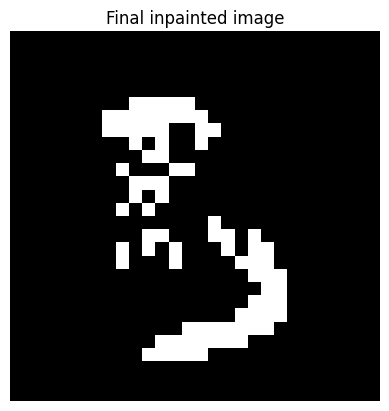

In [76]:
recon = np.clip(recon, 0, 1)
recon[recon < 0.5] = 0
recon[recon >= 0.5] = 1

plt.imshow(recon, cmap="gray")
plt.title("Final inpainted image")
plt.axis("off")
plt.show()

We still need better model, less blur coefficient and better model. 

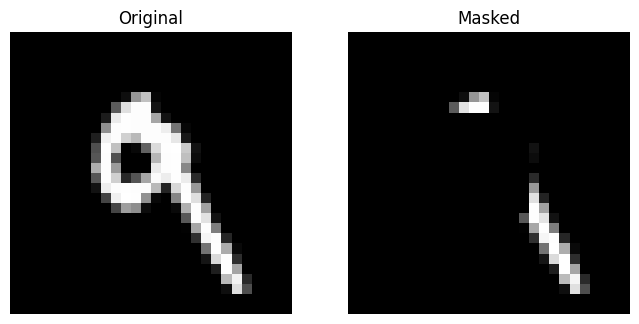

Step 95: 100 valid, 0 degenerate particles
Step 90: 100 valid, 0 degenerate particles
Step 85: 100 valid, 0 degenerate particles
Step 80: 100 valid, 0 degenerate particles
Step 75: 100 valid, 0 degenerate particles
Step 70: 100 valid, 0 degenerate particles
Step 65: 100 valid, 0 degenerate particles
Step 60: 100 valid, 0 degenerate particles
Step 55: 100 valid, 0 degenerate particles
Step 50: 100 valid, 0 degenerate particles
Step 45: 100 valid, 0 degenerate particles
Step 40: 100 valid, 0 degenerate particles
Step 35: 100 valid, 0 degenerate particles
Step 30: 100 valid, 0 degenerate particles
Step 25: 100 valid, 0 degenerate particles
Step 20: 100 valid, 0 degenerate particles
Step 15: 100 valid, 0 degenerate particles
Step 10: 100 valid, 0 degenerate particles
Step 5: 100 valid, 0 degenerate particles
Step 0: 100 valid, 0 degenerate particles


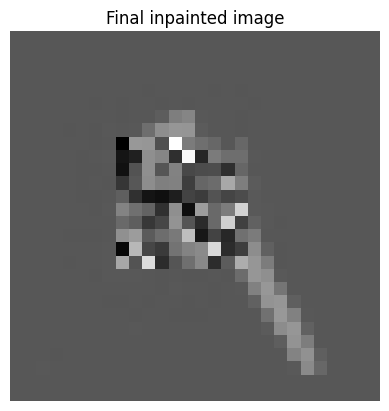

In [19]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn 

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load MNIST ---
mnist = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())
x0, label = mnist[7]
x0 = x0.numpy().squeeze()

# --- Mask ---
mask = np.ones_like(x0)
mask[8:18,8:18] = 0
masked_img = x0 * mask

# --- Flatten for SMC ---
x0_flat = x0.flatten()
mask_flat = mask.flatten().astype(bool)
obs_idx = np.where(mask_flat)[0]
miss_idx = np.where(~mask_flat)[0]
y_obs = x0_flat[obs_idx]
dx = x0_flat.size
dy = len(obs_idx)

# --- Display original and masked ---
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(x0, cmap="gray"); ax[0].set_title("Original"); ax[0].axis("off")
ax[1].imshow(masked_img, cmap="gray"); ax[1].set_title("Masked"); ax[1].axis("off")
plt.show()

# --- Load your trained SmallUNet ---
class ImprovedUNet(nn.Module):
    def __init__(self, in_ch=1, base_ch=64):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(nn.Conv2d(in_ch, base_ch, 3, 1, 1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(base_ch, base_ch*2, 3, 2, 1), nn.ReLU())
        self.enc3 = nn.Sequential(nn.Conv2d(base_ch*2, base_ch*2, 3, 1, 1), nn.ReLU())
        # Decoder
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(base_ch*2, base_ch*2, 4, 2, 1), nn.ReLU())
        self.dec2 = nn.Sequential(nn.Conv2d(base_ch*2, base_ch, 3, 1, 1), nn.ReLU())
        self.out = nn.Conv2d(base_ch, in_ch, 3, 1, 1)

    def forward(self, x, t):
        h = self.enc1(x)
        h = self.enc2(h)
        h = self.enc3(h)
        h = self.dec1(h)
        h = self.dec2(h)
        return self.out(h) 
    

unet = ImprovedUNet().to(device)
unet.load_state_dict(torch.load("models/ddpm_mnist_100_100e_imp_low_beta.pt", map_location=device))
unet.eval()
# --- Forward schedule ---
num_timesteps = 100
beta_start, beta_end = 1e-4, 0.01
betas = np.linspace(beta_start, beta_end, num_timesteps)
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas)
sigmas = np.sqrt(betas)

# --- Backward FK ---
class NoiselessBackwardFK:
    def __init__(self, y, obs_idx, miss_idx, alpha_bars, sigmas, model, dx):
        self.y = y
        self.obs_idx = obs_idx
        self.miss_idx = miss_idx
        self.dy = len(obs_idx)
        self.alpha_bars = alpha_bars
        self.sigmas = sigmas
        self.model = model
        self.dx = dx
        self.nsteps = len(alpha_bars) - 1

    @torch.no_grad()
    def chi(self, x, t):
        x = np.atleast_2d(x)
        N = x.shape[0]
        img_size = int(np.sqrt(self.dx))
        x_img = x.reshape(N, 1, img_size, img_size)
        x_tensor = torch.tensor(x_img, dtype=torch.float32, device=device)
        t_tensor = torch.full((N,), t, device=device, dtype=torch.long)
        eps = self.model(x_tensor, t_tensor).cpu().numpy().reshape(N, -1)
        return x / np.sqrt(self.alpha_bars[t]) - np.sqrt(1 - self.alpha_bars[t]) * eps

    def m(self, x_next, t):
        chi = self.chi(x_next, t + 1)
        sigma2 = self.sigmas[t + 1]**2
        alpha_bar = self.alpha_bars[t + 1]
        Kt = sigma2 / (sigma2 + 1 - alpha_bar)
        mean = chi.copy()
        mean[:, self.obs_idx] = Kt * np.sqrt(alpha_bar) * self.y + (1 - Kt) * chi[:, self.obs_idx]
        return mean

    def M0(self, N):
        particles = np.zeros((N, self.dx))
        alpha_n = self.alpha_bars[-1]
        sigma_n = self.sigmas[-1]
        Kn = sigma_n**2 / (sigma_n**2 + 1 - alpha_n)
        mean_obs = Kn * np.sqrt(alpha_n) * self.y
        cov_obs = (1 - alpha_n) * Kn * np.eye(self.dy)
        particles[:, self.obs_idx] = np.random.multivariate_normal(mean_obs, cov_obs, size=N)
        particles[:, self.miss_idx] = np.random.randn(N, len(self.miss_idx))
        return particles

    def M(self, s, xp):
        mean = self.m(xp, s)
        alpha_s = self.alpha_bars[s]
        sigma_sp1 = self.sigmas[s + 1]
        Ks = sigma_sp1**2 / (sigma_sp1**2 + 1 - alpha_s)
        cov_obs = (1 - alpha_s) * Ks * np.eye(self.dy)
        new_obs = np.array([np.random.multivariate_normal(mean=m[self.obs_idx], cov=cov_obs) for m in mean])
        xp_new = xp.copy()
        xp_new[:, self.obs_idx] = new_obs
        return xp_new

# --- PseudoSMC with snapshot saving ---
class PseudoSMC:
    def __init__(self, fk, N=5, snapshot_dir="./manual_smc_res"):
        self.fk = fk
        self.N = N
        self.snapshot_dir = snapshot_dir
        os.makedirs(snapshot_dir, exist_ok=True)

    def compute_weights(self, particles, s):
        mean = self.fk.m(particles, s)
        cov = self.fk.sigmas[s + 1]**2 + 1 - self.fk.alpha_bars[s]
        log_w = np.zeros(self.N)
        for i in range(self.N):
            diff = np.sqrt(self.fk.alpha_bars[s]) * self.fk.y - mean[i, self.fk.obs_idx]
            log_w[i] = -0.5 * diff @ diff / cov - 0.5 * self.fk.dy * np.log(2 * np.pi * cov)
        log_w -= np.max(log_w)
        w = np.exp(log_w)
        if np.sum(w) == 0 or np.isnan(np.sum(w)):
            return np.ones(self.N) / self.N
        return w / np.sum(w)

    def resample(self, particles, weights):
        idx = np.random.choice(self.N, self.N, replace=True, p=weights)
        return particles[idx]

    def run(self, snapshot_every=5):
        particles = self.fk.M0(self.N)
        for s in reversed(range(self.fk.nsteps)):
            w = self.compute_weights(particles, s)
            particles = self.resample(particles, w)
            particles = self.fk.M(s, particles)
            if s % snapshot_every == 0:
                is_valid = np.all(np.isfinite(particles), axis=1)
                n_valid = np.sum(is_valid)
                n_degen = self.N - n_valid

                if n_valid > 0:
                    recon = particles[is_valid].mean(axis=0).reshape(28, 28)
                else:
                    recon = np.zeros((28,28))

                filename = os.path.join(self.snapshot_dir, f"step_{s:04d}.png")
                plt.imsave(filename, recon, cmap="gray")
                print(f"Step {s}: {n_valid} valid, {n_degen} degenerate particles")
                plt.imsave(os.path.join(self.snapshot_dir, f"step_{s:04d}.png"), recon, cmap="gray")
        return particles

# --- Run full SMC ---
fk = NoiselessBackwardFK(y=y_obs, obs_idx=obs_idx, miss_idx=miss_idx,
                          alpha_bars=alpha_bars, sigmas=sigmas,
                          model=unet, dx=dx)

smc = PseudoSMC(fk, N=100)
particles_final = smc.run(snapshot_every=5)

# --- Show final reconstruction ---
recon = particles_final.mean(axis=0).reshape(28,28)
plt.imshow(recon, cmap="gray")
plt.title("Final inpainted image")
plt.axis("off")
plt.show()


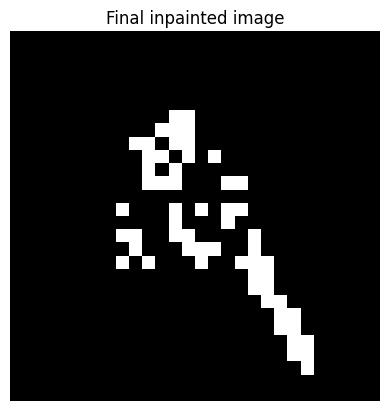

In [20]:
recon = np.clip(recon, 0, 1)
recon[recon < 0.5] = 0
recon[recon >= 0.5] = 1

plt.imshow(recon, cmap="gray")
plt.title("Final inpainted image")
plt.axis("off")
plt.show()

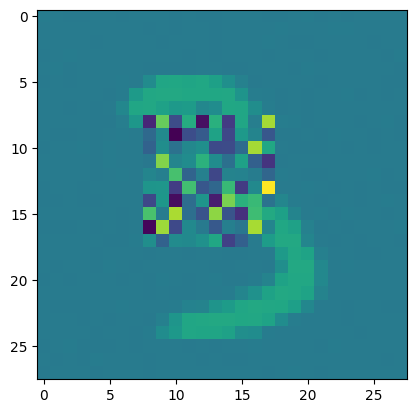

In [18]:
plt.imshow(particles_final[34, ].reshape(28,28))